In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

In [2]:
breast = load_breast_cancer()
df = pd.DataFrame(breast.data, columns=breast.feature_names)
df['diagnosis'] = breast.target

In [3]:
df['diagnosis'].value_counts()

1    357
0    212
Name: diagnosis, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [5]:
# k겹 교차검증(KFold Cross Validation) - 검증의 신뢰성을 위해 검증기관을 여러 개 두는 것.
# train을 k등분해서 돌아가면서 한 부분씩 validation으로 해서 총 k번 검증한다. k회 검증 점수의 평균을 내서 교차검증 정확도를 알아본다.
from sklearn.model_selection import train_test_split, StratifiedKFold

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# 데이터 분할 기계 생성 -> 분할(split) 실행
# shuffle: train을 한 번 섞은 뒤 분할 / false면 stratify가 동작하지 않을 수도 있다..?
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1).split(X_train, y_train)

In [6]:
kfold # generator 객체    

<generator object _BaseKFold.split at 0x000001F9CBF1A740>

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # 차원축소(데이터가 너무 적음)
from sklearn.linear_model import LogisticRegression

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1).split(X_train, y_train)
cvscore = []


for i, (train, val) in enumerate(kfold):

#스케일링    
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train[train])
    X_val_sc = scaler.transform(X_train[val])
    
    
#차원축소    
    pca = PCA(n_components=2)
    X_train_sc = pca.fit_transform(X_train_sc)
    X_val_sc = pca.transform(X_val_sc)
    
#모델학습...    
    model = LogisticRegression(solver='liblinear', random_state=1)
    model.fit(X_train_sc, y_train[train])
    # p_val = model.predict(X_val_sc)
    score = model.score(X_val_sc, y_train[val])
    cvscore.append(score)
    print(f"폴드 {i+1}. 정확도: {score}")
print("\n CV 정확도:", np.mean(cvscore))

폴드 1. 정확도: 1.0
폴드 2. 정확도: 0.9347826086956522
폴드 3. 정확도: 0.9130434782608695
폴드 4. 정확도: 0.9347826086956522
폴드 5. 정확도: 0.9782608695652174
폴드 6. 정확도: 0.9333333333333333
폴드 7. 정확도: 0.9333333333333333
폴드 8. 정확도: 0.9777777777777777
폴드 9. 정확도: 0.9555555555555556
폴드 10. 정확도: 0.9333333333333333

 CV 정확도: 0.9494202898550725


In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline


#make_pipeline(스케일링 모듈, 차원축소 모듈, 모델학습 모듈 넣기,)
lr_pipe=make_pipeline(StandardScaler(),
                      PCA(n_components=2), 
                      LogisticRegression(solver='liblinear', 
                                         #penalty='l2',
                                         random_state=1))

#fit할 때는 lr_pipe.fit(X_train, y_train)
#predict 할 때는 lr_pipe.predict(X_test)


#cross_val_score(estimator=ㅣr_pipe, X=?, y=?, cv=?)
cvsore=cross_val_score(estimator=lr_pipe, X=X_train, y=y_train, cv=10, n_jobs=-1) #estimator 추정기

#cv=10 10개 복제함. 10조각을 내서 10개의 k폴더를 생성람

#score=f1_score
#mean_squared_error(y,p)
#(실제값, 예측값)


#엔잡스가 1으로 하면 차례대로 갈 것, 10개면 병렬로 한꺼번에 됨.

print("\n CV 정확도:", np.mean(cvscore))


 CV 정확도: 0.9494202898550725


In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# 머신러닝 파이프라인
# 파이프 라인 : 한쪽 입구에 데이터를 넣으면 통로를 따라 쭉 흘러가면서 
#               스케일링, 차원축소, 모델학습 하는 일련의 과정이 
#               유기적으로 연결돼서 자동화 된것 -> 최종 결과만 툭 나오는 것
# 스케일링, 차원축소, 모델학습 순서대로 넣기

lr_pipe = make_pipeline(StandardScaler(),
                        # PCA(n_components=2),
                        LogisticRegression(solver='liblinear', random_state=1, penalty='l2')) # 규제항: ridge (손실함수와 만나는 접점이 최소)
# model = LogisticRegression(solver='liblinear', random_state=1)

# lr_pipe.fit(X_train, y_train)
# lr_pipe.predict(X_test)

cvscore = cross_val_score(estimator=lr_pipe, X=X_train, y=y_train, cv=10, n_jobs=-1)

# n_jobs=-1: 연산에 모든 프로세스 사용

print("CV 정확도:", np.mean(cvscore))

CV 정확도: 0.973623188405797


In [26]:
from sklearn.model_selection import learning_curve

# 학습곡선 그리기
# lr_pipe = make_pipeline(StandardScaler(),
#                         PCA(n_components=2),
#                         LogisticRegression(solver='liblinear', random_state=1))

# 100번의 단계를 10번씩 수행해서 2차원 배열이 된다.

sizes, train_score, val_score = learning_curve(estimator=lr_pipe, X=X_train, y=y_train, train_sizes=np.linspace(0.01, 1.0, 10), cv=10, n_jobs=-1)


In [10]:
X_train.shape

(455, 30)

In [11]:
train_score

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [0.87755102, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.92553191, 0.95744681, 0.95744681, 0.94680851, 0.94680851,
        0.94680851, 0.94680851, 0.94680851, 0.94680851, 0.94680851],
       [0.9352518 , 0.96402878, 0.96402878, 0.9352518 , 0.9352518 ,
        0.9352518 , 0.9352518 , 0.9352518 , 0.9352518 , 0.9352518 ],
       [0.94565217, 0.97282609, 0.96195652, 0.94021739, 0.96195652,
        0.94565217, 0.94565217, 0.94565217, 0.94565217, 0.94565217],
       [0.95196507, 0.97379913, 0.9650655 , 0.9650655 , 0.95633188,
        0.96069869, 0.95633188, 0.95633188, 0.95633188, 0.95633188],
       [0.95985401, 0.96715328, 0.96350365, 0.96350365, 0.95620438,
        0.95985401, 0.97080292, 0.96715328, 0.96715328, 0.96715328],
       [0.95611285, 0.96238245, 0.9623824

In [12]:
val_score

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [0.91304348, 0.86956522, 0.89130435, 0.95652174, 0.89130435,
        0.95555556, 0.95555556, 0.91111111, 0.91111111, 0.93333333],
       [0.93478261, 0.93478261, 0.93478261, 0.97826087, 0.84782609,
        0.97777778, 0.91111111, 0.95555556, 0.91111111, 0.95555556],
       [0.95652174, 0.93478261, 0.93478261, 0.97826087, 0.91304348,
        0.95555556, 0.95555556, 0.93333333, 0.91111111, 0.95555556],
       [0.97826087, 0.93478261, 0.93478261, 1.        , 0.89130435,
        0.95555556, 0.95555556, 0.93333333, 0.93333333, 0.95555556],
       [0.95652174, 0.93478261, 0.95652174, 0.93478261, 0.91304348,
        0.97777778, 0.93333333, 0.93333333, 0.93333333, 0.95555556],
       [0.97826087, 0.93478261, 0.95652174, 0.97826087, 0.91304348,
        0.97777778, 0.93333333, 0.93333333, 0.93333333, 0.95555556],
       [0.97826087, 0.93478261, 0.9565217

In [78]:
val_score.shape #(train_sizes, cv)

(10, 10)

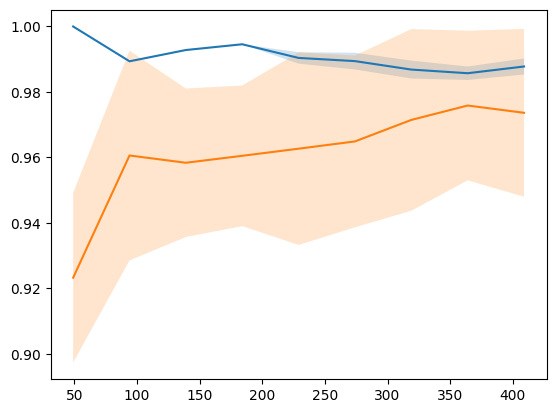

In [27]:
import matplotlib.pyplot as plt

# 학습곡선은 학습이 얼마나 됐는지 확인하기 위해서 그리는 것이다.

# 첫번째 ~ 100번째 10번 시행했을 때 각각의 평균

train_mean = np.mean(train_score, axis=1)
val_mean = np.mean(val_score, axis=1)

# 교차 검증한 10개 값의 표준편차

train_std = np.std(train_score, axis=1)
val_std = np.std(val_score, axis=1)

plt.figure()

# train_score에 대한 학습곡선과 표준편차 밴드 표현

plt.plot(sizes, train_mean)
plt.fill_between(sizes, train_mean+train_std, train_mean-train_std, alpha=0.2) # x축, y축 최대, y축 최소

# val_score에 대한 학습곡선과 표준편차 밴드 표현

plt.plot(sizes, val_mean)
plt.fill_between(sizes, val_mean+val_std, val_mean-val_std, alpha=0.2) # x축, y축 최대, y축 최소

plt.show()

In [28]:
#np.logspace(start, stop,n, base=10)

C_range=np.logspace(-3, 2, 6) 

#6은 -3과 2 사이 숫자 개수이다.

In [29]:
train_score.shape

(10, 10)

In [30]:
#검증 곡선


from sklearn.model_selection import validation_curve

C_range = np.logspace(-3, 2, 6, base=10) # 밑이 10 -> 10 ** start, 10 ** stop

# lr_pipe = make_pipeline(StandardScaler(),
#                         PCA(n_components=2),
#                         LogisticRegression(solver='liblinear', random_state=1))

# C는 6개, cv는 10겹

train_score, val_score = validation_curve(estimator=lr_pipe, X=X_train, y=y_train,
                                                 param_name='logisticregression__C', param_range=C_range, cv=10, n_jobs=-1)

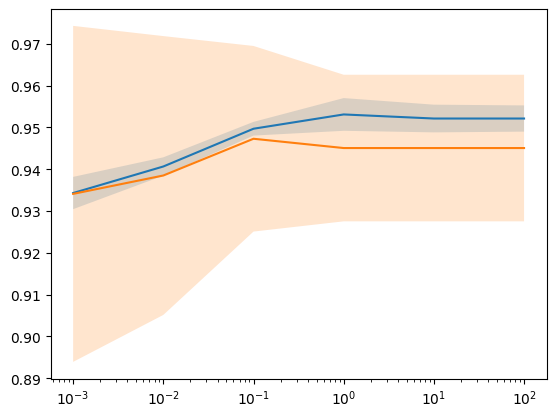

In [17]:
import matplotlib.pyplot as plt

# validation_curve 시각화

train_mean = np.mean(train_score, axis=1)
val_mean = np.mean(val_score, axis=1)

# 교차 검증한 10개 값의 표준편차
train_std = np.std(train_score, axis=1)
val_std = np.std(val_score, axis=1)

plt.figure()
# train_score에 대한 학습곡선과 표준편차 밴드 표현
plt.plot(C_range, train_mean)
plt.fill_between(C_range, train_mean+train_std, train_mean-train_std, alpha=0.2) # x축, y축 최대, y축 최소

# val_score에 대한 학습곡선과 표준편차 밴드 표현
plt.plot(C_range, val_mean)
plt.fill_between(C_range, val_mean+val_std, val_mean-val_std, alpha=0.2) # x축, y축 최대, y축 최소

plt.xscale("log")
plt.show()

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc_pipe = make_pipeline(StandardScaler(), SVC(random_state=1))
C_range = np.logspace(-4, 3, 8)
gamma_range = np.logspace(-4, 3, 8)#-4승부터 3승까지
param_grid = [{'svc__C': C_range, 'svc__kernel': ['linear']}, {'svc__C': C_range, 'svc__gamma': gamma_range, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=svc_pipe, param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=-1) #scoring: 최적의 값을 찾을 때 무엇을 보고 찾을 것인가

In [19]:
gs = gs.fit(X_train, y_train)

In [20]:
gs.best_score_

0.9758454106280192

In [21]:
gs.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10.0, gamma=0.001, random_state=1))])

In [22]:
gs.best_params_

{'svc__C': 10.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

lr_gs=GridSearchCV(estimator=LogisticRegression, cv=2)
svc_gs= GridSearchCV(estimator=SVC)
forest_gs=...

lr_score=cross_val_score(estimator=lr_gs, cv=5)#교차검증하는 함수
svc_score=cross_val_score(estimator=svc_gs)
forest_score =cross_val_score(estimator=forest_gs)